In [213]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [215]:
df = pd.read_csv(f'../data/PIKK/2020-10-01 - 2021-10-02.csv', index_col=0, parse_dates=['time'], dayfirst=True)
df.head()

,figi,interval,o,c,h,l,v,time
0,BBG004S68BH6,15min,569.7,569.7,570.2,567.5,294,2020-10-01 07:00:00+00:00
1,BBG004S68BH6,15min,570.0,569.7,570.3,569.4,185,2020-10-01 07:15:00+00:00
2,BBG004S68BH6,15min,570.0,570.2,570.3,569.5,138,2020-10-01 07:30:00+00:00
3,BBG004S68BH6,15min,570.0,570.6,570.6,570.0,255,2020-10-01 07:45:00+00:00
4,BBG004S68BH6,15min,570.8,570.9,571.0,570.4,235,2020-10-01 08:00:00+00:00


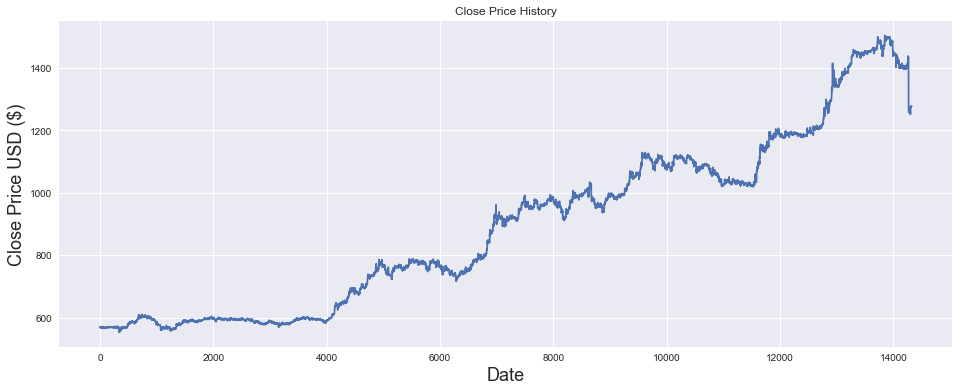

In [216]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['c'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [219]:
test_size = 74
data = df.filter('c')
dataset = data.values
train_df = dataset[:-test_size]
test_df = dataset[-test_size:]

In [220]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_df)
scaled_data

array([[0.01631236],
       [0.01631236],
       [0.01683856],
       ...,
       [0.89644285],
       [0.89170701],
       [0.89360135]])

In [221]:
x_train = []
y_train = []

for i in range(test_size, len(scaled_data)):
    x_train.append(scaled_data[i - test_size:i])
    y_train.append(scaled_data[i])

x_train = np.array(x_train)
y_train = np.array(y_train)


In [222]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [223]:
%%time

model.fit(x_train, y_train, batch_size=1, epochs=1)

14178/14178 [==============================] - 208s 15ms/step - loss: 2.8363e-04

In [224]:
x_test = x_train[len(x_train) - 1:].copy()
predictions = []

for i in range(len(test_df)):
    predictions.append(model.predict(x_test).tolist())
    x_test = np.append(x_test[0][1:], predictions[i])
    x_test = x_test.reshape(1, 74, 1)

In [225]:
predictions = np.array(predictions)
predictions = predictions.reshape(74, 1)
predictions = scaler.inverse_transform(predictions)

In [226]:
train = data[:-test_size]
valid = data[-test_size:]
valid['Predicted'] = predictions
valid

C:\Users\spark\AppData\Local\Temp/ipykernel_10920/1580747980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicted'] = predictions


,c,Predicted
14252,1405.3,1412.788409
14253,1405.2,1416.593860
14254,1405.0,1421.224390
14255,1408.0,1425.916541
14256,1408.8,1430.388262
...,...,...
14321,1276.8,1616.785515
14322,1276.7,1618.579641
14323,1277.0,1620.341824
14324,1277.8,1622.072404


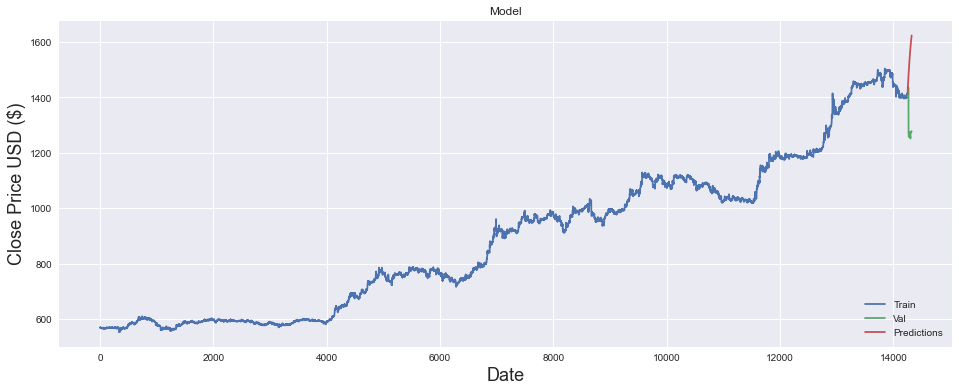

In [227]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['c'])
plt.plot(valid[['c', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

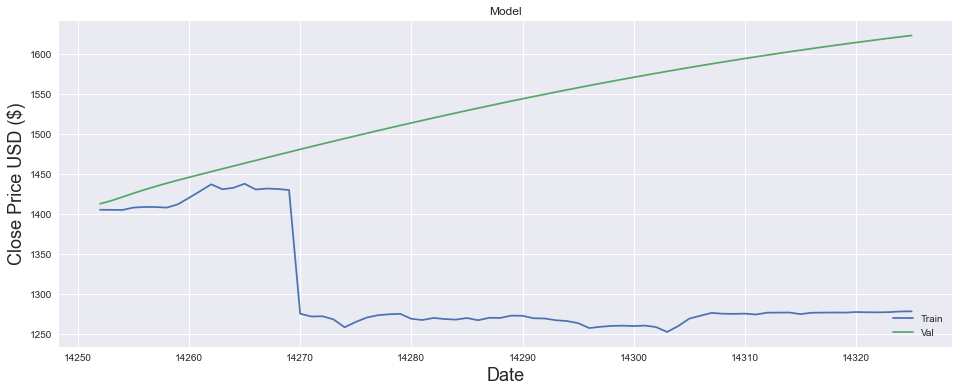

In [228]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['c', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()